<a href="https://colab.research.google.com/github/lolobq/ECGR-5106-Intro_To_Deep_Learning/blob/main/Homework2/DeepLearningHomework2Problem1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries and Data


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchsummary import summary
from sklearn.metrics import classification_report, confusion_matrix
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Problem 1 No Dropout

AlexNet is originally proposed for 227*227 image sizes. It may be too complex for the CIFAR-10 dataset, in particular, due to the low resolution of the initial images; try simplifying the model to make the training faster while ensuring that the accuracy stays relatively high. Report the training loss, validation loss, and validation accuracy. Also, report the number of parameters in your modified version of AlexNet and compare it against the number of parameters in the original AlexNet architectures. Here is a good reference guide to AlexNet: https://www.kaggle.com/code/blurredmachine/alexnet-architecture-a-complete-guideLinks to an external site.

Explore the option of applying Dropout techniques for training your customized AlexNet. Compare the training and validation results against the baseline model without any dropout.

In [13]:
# Load CIFAR-10 dataset to calculate mean and std
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transforms.ToTensor())

# Calculate mean and std
imgs = torch.stack([img_t for img_t, _ in train_dataset], dim=3)
mean = imgs.view(3, -1).mean(dim=1)
std = imgs.view(3, -1).std(dim=1)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define transformation with calculated mean and std
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

# Load CIFAR-10 dataset with normalization
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Define simplified AlexNet model
class SimplifiedAlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(SimplifiedAlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=1),

            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=1),

            nn.Conv2d(128, 394, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(394, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=1),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((4, 4))
        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Initialize the network
net = SimplifiedAlexNet().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

training_losses = []
training_accuracies = []

validation_losses = []
validation_accuracies = []

num_epochs = 15

# Training the network
for epoch in range(num_epochs):  # Train for 10 epochs
    net.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    training_loss = running_loss / len(train_loader)
    training_losses.append(training_loss)
    training_accuracy = 100 * correct / total
    training_accuracies.append(training_accuracy)

    # Testing the network
    net.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_predicted = []
    true_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            images, labels = inputs.to(device), labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_predicted.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Update validation accuracy + loss
    validation_loss = running_loss / len(test_loader.dataset)
    validation_losses.append(validation_loss)
    validation_accuracy = 100 * correct / total
    validation_accuracies.append(validation_accuracy)

    # Print training statistics
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {training_loss}, Validation Loss: {validation_loss}, Validation Accuracy: {validation_accuracy}')

    # Set the model back to training mode
    net.train()

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Epoch 1/15, Training Loss: 1.876149819969597, Validation Loss: 0.0524137885093689, Validation Accuracy: 37.57
Epoch 2/15, Training Loss: 1.5100188391451186, Validation Loss: 0.04450443651676178, Validation Accuracy: 49.6
Epoch 3/15, Training Loss: 1.3496701318487019, Validation Loss: 0.041605045068264006, Validation Accuracy: 52.36
Epoch 4/15, Training Loss: 1.2399004676444212, Validation Loss: 0.03802745399475098, Validation Accuracy: 57.35
Epoch 5/15, Training Loss: 1.151361163236053, Validation Loss: 0.03772904511094093, Validation Accuracy: 57.77
Epoch 6/15, Training Loss: 1.079665248049274, Validation Loss: 0.035248500841856004, Validation Accuracy: 61.63
Epoch 7/15, Training Loss: 1.0199534285739684, Validation Loss: 0.03502149686217308, Validation Accuracy: 61.91
Epoch 8/15, Training Loss: 0.9614355911334508, Validation Loss: 0.03314565960168839, Validation Accuracy:

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 7, 7]          23,296
              ReLU-2             [-1, 64, 7, 7]               0
         MaxPool2d-3             [-1, 64, 5, 5]               0
            Conv2d-4            [-1, 128, 5, 5]         204,928
              ReLU-5            [-1, 128, 5, 5]               0
         MaxPool2d-6            [-1, 128, 3, 3]               0
            Conv2d-7            [-1, 394, 3, 3]         454,282
              ReLU-8            [-1, 394, 3, 3]               0
            Conv2d-9            [-1, 256, 3, 3]         908,032
             ReLU-10            [-1, 256, 3, 3]               0
           Conv2d-11            [-1, 256, 3, 3]         590,080
             ReLU-12            [-1, 256, 3, 3]               0
        MaxPool2d-13            [-1, 256, 1, 1]               0
AdaptiveAvgPool2d-14            [-1, 25

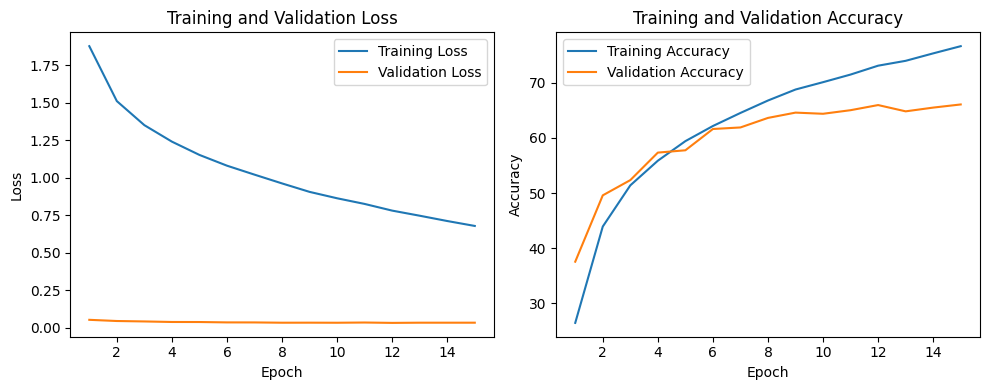

              precision    recall  f1-score   support

           0       0.75      0.68      0.72      1000
           1       0.83      0.66      0.73      1000
           2       0.64      0.49      0.55      1000
           3       0.47      0.43      0.45      1000
           4       0.61      0.63      0.62      1000
           5       0.51      0.66      0.58      1000
           6       0.71      0.74      0.72      1000
           7       0.76      0.69      0.72      1000
           8       0.79      0.81      0.80      1000
           9       0.62      0.82      0.71      1000

    accuracy                           0.66     10000
   macro avg       0.67      0.66      0.66     10000
weighted avg       0.67      0.66      0.66     10000



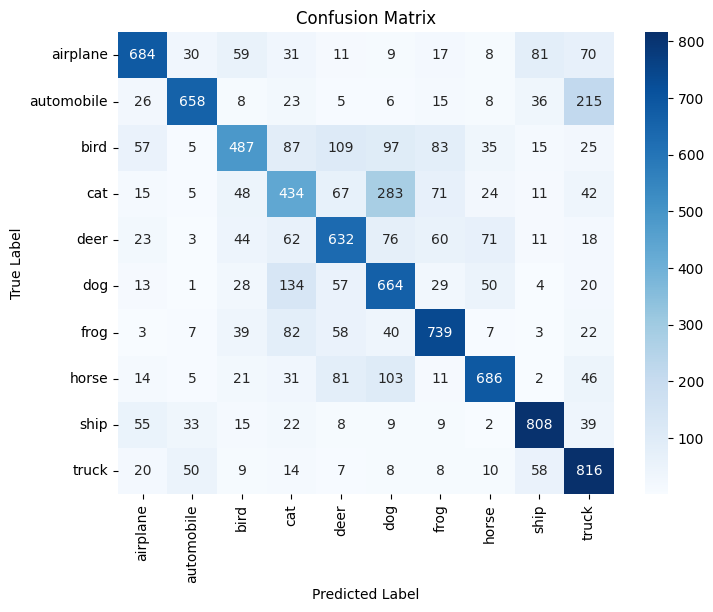

In [15]:
summary(net, (3, 32, 32))  # Input images have shape (3, 32, 32)
print(f'Final Training Loss: {training_losses[-1]}')
print(f'Final Validation Loss: {validation_losses[-1]}')
print(f'Final Training Accuracy : {training_accuracies[-1]} %')
print(f'Final Validation Accuracy : {validation_accuracies[-1]} %')
epochs_range = range(1, num_epochs + 1)

# Plot Training Loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_losses, label='Training Loss')
plt.plot(epochs_range, validation_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_accuracies, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

conf_matrix = confusion_matrix(true_labels, all_predicted)
report = classification_report(true_labels, all_predicted)
print(report)

class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Problem 1 With Dropout

In [16]:
# Define simplified AlexNet model
class SimplifiedAlexNetDropout(nn.Module):
    def __init__(self, num_classes=10):
        super(SimplifiedAlexNetDropout, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=1),

            nn.Conv2d(64, 128, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=1),

            nn.Conv2d(128, 394, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(394, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=1),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((4, 4))
        self.classifier = nn.Sequential(
            nn.Linear(256 * 4 * 4, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Initialize the network
net = SimplifiedAlexNetDropout().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

training_losses = []
training_accuracies = []

validation_losses = []
validation_accuracies = []

num_epochs = 15

# Training the network
for epoch in range(num_epochs):  # Train for 10 epochs
    net.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    training_loss = running_loss / len(train_loader)
    training_losses.append(training_loss)
    training_accuracy = 100 * correct / total
    training_accuracies.append(training_accuracy)

    # Testing the network
    net.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_predicted = []
    true_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            images, labels = inputs.to(device), labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_predicted.extend(predicted.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Update validation accuracy + loss
    validation_loss = running_loss / len(test_loader.dataset)
    validation_losses.append(validation_loss)
    validation_accuracy = 100 * correct / total
    validation_accuracies.append(validation_accuracy)

    # Print training statistics
    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {training_loss}, Validation Loss: {validation_loss}, Validation Accuracy: {validation_accuracy}')

    # Set the model back to training mode
    net.train()

Epoch 1/15, Training Loss: 1.8803028041402727, Validation Loss: 0.04984747943878174, Validation Accuracy: 40.88
Epoch 2/15, Training Loss: 1.542687753302427, Validation Loss: 0.044983928513526915, Validation Accuracy: 48.47
Epoch 3/15, Training Loss: 1.3863825457491177, Validation Loss: 0.04073955457806587, Validation Accuracy: 54.09
Epoch 4/15, Training Loss: 1.279464740632668, Validation Loss: 0.039323122334480286, Validation Accuracy: 55.81
Epoch 5/15, Training Loss: 1.2105566808907404, Validation Loss: 0.03801713300943375, Validation Accuracy: 57.8
Epoch 6/15, Training Loss: 1.147802885800543, Validation Loss: 0.03759989019632339, Validation Accuracy: 57.46
Epoch 7/15, Training Loss: 1.0956173054087415, Validation Loss: 0.03770650495886803, Validation Accuracy: 58.9
Epoch 8/15, Training Loss: 1.047353447722992, Validation Loss: 0.03485374506115913, Validation Accuracy: 62.02
Epoch 9/15, Training Loss: 1.0135109203981423, Validation Loss: 0.03490670366883278, Validation Accuracy: 61

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 64, 7, 7]          23,296
              ReLU-2             [-1, 64, 7, 7]               0
         MaxPool2d-3             [-1, 64, 5, 5]               0
            Conv2d-4            [-1, 128, 5, 5]         204,928
              ReLU-5            [-1, 128, 5, 5]               0
         MaxPool2d-6            [-1, 128, 3, 3]               0
            Conv2d-7            [-1, 394, 3, 3]         454,282
              ReLU-8            [-1, 394, 3, 3]               0
            Conv2d-9            [-1, 256, 3, 3]         908,032
             ReLU-10            [-1, 256, 3, 3]               0
           Conv2d-11            [-1, 256, 3, 3]         590,080
             ReLU-12            [-1, 256, 3, 3]               0
        MaxPool2d-13            [-1, 256, 1, 1]               0
AdaptiveAvgPool2d-14            [-1, 25

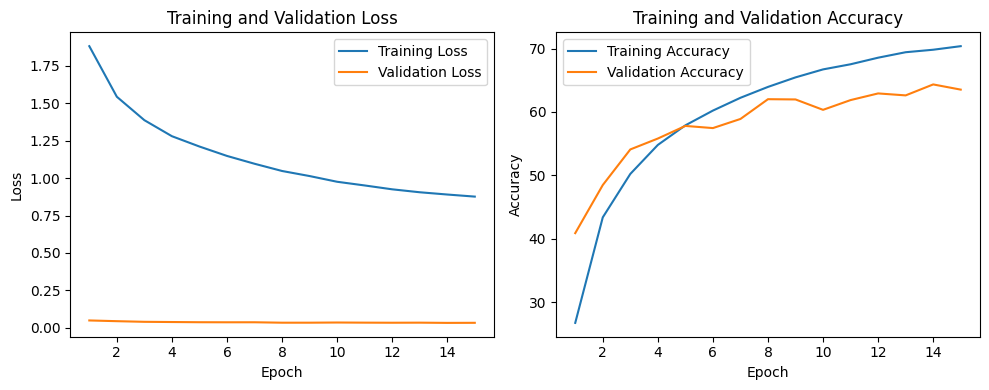

              precision    recall  f1-score   support

           0       0.78      0.61      0.68      1000
           1       0.64      0.82      0.72      1000
           2       0.54      0.55      0.55      1000
           3       0.41      0.44      0.43      1000
           4       0.52      0.67      0.59      1000
           5       0.53      0.58      0.55      1000
           6       0.76      0.64      0.70      1000
           7       0.72      0.75      0.73      1000
           8       0.82      0.74      0.78      1000
           9       0.79      0.56      0.65      1000

    accuracy                           0.64     10000
   macro avg       0.65      0.64      0.64     10000
weighted avg       0.65      0.64      0.64     10000



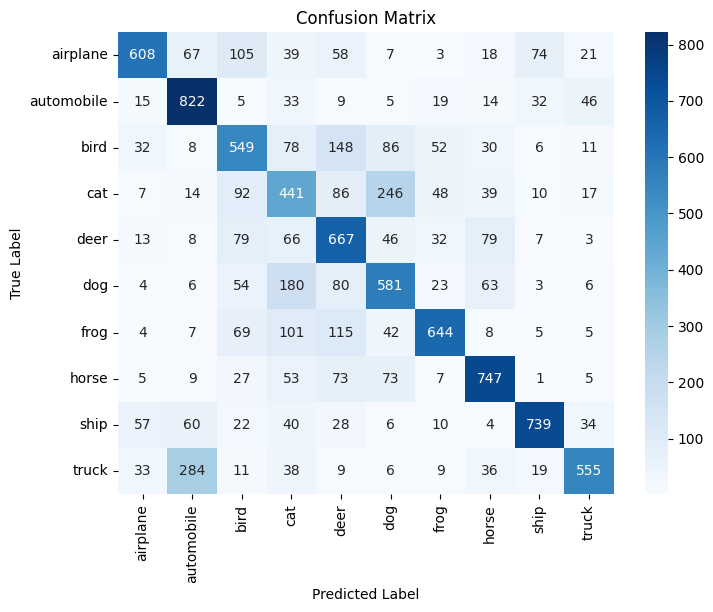

In [17]:
summary(net, (3, 32, 32))  # Input images have shape (3, 32, 32)
print(f'Final Training Loss: {training_losses[-1]}')
print(f'Final Validation Loss: {validation_losses[-1]}')
print(f'Final Training Accuracy : {training_accuracies[-1]} %')
print(f'Final Validation Accuracy : {validation_accuracies[-1]} %')
epochs_range = range(1, num_epochs + 1)

# Plot Training Loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_losses, label='Training Loss')
plt.plot(epochs_range, validation_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot Training and Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_accuracies, label='Training Accuracy')
plt.plot(epochs_range, validation_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

conf_matrix = confusion_matrix(true_labels, all_predicted)
report = classification_report(true_labels, all_predicted)
print(report)

class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()